# Reconstruction of a positive-real wavefunction

This tutorial shows how to reconstruct a **positive-real** wavefunction via training a *Restricted Boltzmann Machine* (RBM), the neural network behind QuCumber. The data used for training are $\sigma^{z}$ measurements from a one-dimensional transverse-field Ising model (TFIM) with 10 sites at its critical point.

## Transverse-field Ising model
The example dataset, located in `tfim1d_data.txt`, comprises 10,000 $\sigma^{z}$ measurements from a one-dimensional TFIM with 10 sites at its critical point. The Hamiltonian for the TFIM is given by

$$H = -J\sum_i \sigma^z_i \sigma^z_{i+1} - h \sum_i\sigma^x_i$$

where $\sigma^{z}_i$ is the conventional spin-1/2 Pauli operator on site $i$. At the critical point, $J=h=1$. By convention, spins are represented in binary notation with zero and one denoting the states spin-down and spin-up, respectively.

## Using QuCumber to reconstruct the wavefunction

### Imports
To begin the tutorial, first import the required Python packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qucumber.nn_states import PositiveWaveFunction
from qucumber.callbacks import MetricEvaluator

import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data
import qucumber

# set random seed on cpu but not gpu, since we won't use gpu for this tutorial
qucumber.set_random_seed(1234, cpu=True, gpu=False)

The Python class `PositiveWaveFunction` contains generic properties of a RBM meant to reconstruct a positive-real wavefunction, the most notable one being the gradient function required for stochastic gradient descent.

To instantiate a `PositiveWaveFunction` object, one needs to specify the number of visible and hidden units in the RBM. The number of visible units, `num_visible`, is given by the size of the physical system, i.e. the number of spins or qubits (10 in this case), while the number of hidden units, `num_hidden`, can be varied to change the expressiveness of the neural network.

**Note:** The optimal `num_hidden` : `num_visible` ratio will depend on the system. For the TFIM, having this ratio be equal to 1 leads to good results with reasonable computational effort.

### Training
To evaluate the training in real time, we compute the fidelity between the true ground-state wavefunction of the system and the wavefunction that QuCumber reconstructs, $\vert\langle\psi\vert\psi_{RBM}\rangle\vert^2$, along with the Kullback-Leibler (KL) divergence (the RBM's cost function). As will be shown below, any custom function can be used to evaluate the training.

First, the training data and the true wavefunction of this system must be loaded using the `data` utility.

In [2]:
psi_path = "tfim1d_psi.txt"
train_path = "tfim1d_data.txt"
train_data, true_psi = data.load_data(train_path, psi_path)

As previously mentioned, to instantiate a `PositiveWaveFunction` object, one needs to specify the number of visible and hidden units in the RBM; we choose them to be equal.

In [3]:
nv = train_data.shape[-1]
nh = nv

nn_state = PositiveWaveFunction(num_visible=nv, num_hidden=nh, gpu=False)

<<<<<<< local
By default, QuCumber will attempt to run on a GPU, and default to CPU if GPU is not available. To run QuCumber on a CPU, add the flag `gpu=False` in the `PositiveWaveFunction` object instantiation (i.e. uncomment the line above). 
=======
If `gpu=True` (the default), QuCumber will attempt to run on a GPU if one is available (otherwise, QuCumber will default to CPU). If one `gpu=False`, QuCumber will run on the CPU.
>>>>>>> remote

Now we specify the hyperparameters of the training process:

1. `epochs`: the total number of training cycles that will be performed (default = 100)
2. `pbs` (`pos_batch_size`): the number of data points used in the positive phase of the gradient (default = 100)
3. `nbs` (`neg_batch_size`): the number of data points used in the negative phase of the gradient (default = 100)
4. `k`: the number of contrastive divergence steps (default = 1)
5. `lr`: the learning rate (default = 0.001)

    **Note:** For more information on the hyperparameters above, it is strongly encouraged that the user to read through the brief, but thorough theory document on RBMs located in the QuCumber documentation. One does not have to specify these hyperparameters, as their default values will be used without the user overwriting them. It is recommended to keep with the default values until the user has a stronger grasp on what these hyperparameters mean. The quality and the computational efficiency of the training will highly depend on the choice of hyperparameters. As such, playing around with the hyperparameters is almost always necessary. 
    
For the TFIM with 10 sites, the following hyperparameters give excellent results:

In [4]:
epochs = 500
pbs = 100
nbs = pbs
lr = 0.01
k = 10

For evaluating the training in real time, the `MetricEvaluator` is called every 100 epochs in order to calculate the training evaluators. The `MetricEvaluator` requires the following arguments:

1. `period`: the frequency of the training evaluators being calculated (e.g. `period=100` means that the `MetricEvaluator` will do an evaluation every 100 epochs)
2. A dictionary of functions you would like to reference to evaluate the training (arguments required for these functions are keyword arguments placed after the dictionary)

The following additional arguments are needed to calculate the fidelity and KL divergence in the `training_statistics` utility:

- `target_psi`: the true wavefunction of the system
- `space`: the Hilbert space of the system

The training evaluators can be printed out via the `verbose=True` statement.

Although the fidelity and KL divergence are excellent training evaluators, they are not practical to calculate in most cases; the user may not have access to the target wavefunction of the system, nor may generating the Hilbert space of the system be computationally feasible. However, evaluating the training in real time is extremely convenient. 

Any custom function that the user would like to use to evaluate the training can be given to the `MetricEvaluator`, thus avoiding having to calculate fidelity and/or KL divergence. Any custom function given to `MetricEvaluator` must take the neural-network state (in this case, the `PositiveWaveFunction` object) and keyword arguments. As an example, we define a custom function `psi_coefficient`, which is the fifth coefficient of the reconstructed wavefunction multiplied by a parameter $A$.

In [5]:
def psi_coefficient(nn_state, space, A, **kwargs):
    norm = nn_state.compute_normalization(space).sqrt_()
    return A * nn_state.psi(space)[0][4] / norm

Now the Hilbert space of the system can be generated for the fidelity and KL divergence.

In [6]:
period = 10
space = nn_state.generate_hilbert_space(nv)

Now the training can begin. The `PositiveWaveFunction` object has a property called `fit` which takes care of this. `MetricEvaluator` must be passed to the `fit` function in a list (`callbacks`).

In [7]:
callbacks = [
    MetricEvaluator(
        period,
        {"Fidelity": ts.fidelity, "KL": ts.KL, "A_Ψrbm_5": psi_coefficient},
        target_psi=true_psi,
        verbose=True,
        space=space,
        A=3.0,
    )
]

nn_state.fit(
    train_data,
    epochs=epochs,
    pos_batch_size=pbs,
    neg_batch_size=nbs,
    lr=lr,
    k=k,
    callbacks=callbacks,
)

<<<<<<< local <modified: >


Epoch: 10	Fidelity = 0.526148	KL = 1.310731	A_Ψrbm_5 = 0.125463
Epoch: 20	Fidelity = 0.631814	KL = 0.875887	A_Ψrbm_5 = 0.193193
Epoch: 30	Fidelity = 0.736986	KL = 0.577408	A_Ψrbm_5 = 0.249697
Epoch: 40	Fidelity = 0.794626	KL = 0.445550	A_Ψrbm_5 = 0.267554
Epoch: 50	Fidelity = 0.828487	KL = 0.363523	A_Ψrbm_5 = 0.263156
Epoch: 60	Fidelity = 0.861033	KL = 0.284768	A_Ψrbm_5 = 0.255909
Epoch: 70	Fidelity = 0.888133	KL = 0.226607	A_Ψrbm_5 = 0.251317
Epoch: 80	Fidelity = 0.904473	KL = 0.191903	A_Ψrbm_5 = 0.230342
Epoch: 90	Fidelity = 0.916896	KL = 0.168523	A_Ψrbm_5 = 0.232834
Epoch: 100	Fidelity = 0.925543	KL = 0.151414	A_Ψrbm_5 = 0.226578
Epoch: 110	Fidelity = 0.933069	KL = 0.136249	A_Ψrbm_5 = 0.227657
Epoch: 120	Fidelity = 0.939533	KL = 0.122066	A_Ψrbm_5 = 0.216086
Epoch: 130	Fidelity = 0.945398	KL = 0.109634	A_Ψrbm_5 = 0.210336
Epoch: 140	Fidelity = 0.950329	KL = 0.099964	A_Ψrbm_5 = 0.214536
Epoch: 150	Fidelity = 0.954255	KL = 0.092397	A_Ψrbm_5 = 0.212398
Epoch: 160	Fidelity = 0.957539	KL 

Epoch: 10	Fidelity = 0.500644	KL = 1.434448	A_Ψrbm_5 = 0.107291
Epoch: 20	Fidelity = 0.570024	KL = 1.101208	A_Ψrbm_5 = 0.142605
Epoch: 30	Fidelity = 0.681412	KL = 0.714396	A_Ψrbm_5 = 0.191203
Epoch: 40	Fidelity = 0.782161	KL = 0.456233	A_Ψrbm_5 = 0.220676
Epoch: 50	Fidelity = 0.840339	KL = 0.326463	A_Ψrbm_5 = 0.232987
Epoch: 60	Fidelity = 0.874599	KL = 0.252754	A_Ψrbm_5 = 0.233641
Epoch: 70	Fidelity = 0.896356	KL = 0.211800	A_Ψrbm_5 = 0.244065
Epoch: 80	Fidelity = 0.907765	KL = 0.190976	A_Ψrbm_5 = 0.245164
Epoch: 90	Fidelity = 0.914902	KL = 0.177813	A_Ψrbm_5 = 0.241192
Epoch: 100	Fidelity = 0.920034	KL = 0.168093	A_Ψrbm_5 = 0.239279
Epoch: 110	Fidelity = 0.924572	KL = 0.159173	A_Ψrbm_5 = 0.241092
Epoch: 120	Fidelity = 0.928750	KL = 0.150047	A_Ψrbm_5 = 0.238522
Epoch: 130	Fidelity = 0.932890	KL = 0.140706	A_Ψrbm_5 = 0.239106
Epoch: 140	Fidelity = 0.937290	KL = 0.130549	A_Ψrbm_5 = 0.238381
Epoch: 150	Fidelity = 0.941908	KL = 0.120102	A_Ψrbm_5 = 0.244220
Epoch: 160	Fidelity = 0.947187	KL 

>>>>>>> remote <modified: >


All of these training evaluators can be accessed after the training has completed. The code below shows this, along with plots of each training evaluator as a function of epoch (training cycle number).

In [8]:
# Note that the key given to the *MetricEvaluator* must be
# what comes after callbacks[0].
fidelities = callbacks[0].Fidelity

# Alternatively, we can use the usual dictionary/list subsripting
# syntax. This is useful in cases where the name of the
# metric contains special characters or spaces.
KLs = callbacks[0]["KL"]
coeffs = callbacks[0]["A_Ψrbm_5"]

epoch = np.arange(period, epochs + 1, period)

In [9]:
# Some parameters to make the plots look nice
params = {
    "text.usetex": True,
    "font.family": "serif",
    "legend.fontsize": 14,
    "figure.figsize": (10, 3),
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "lines.linewidth": 2,
    "lines.markeredgewidth": 0.8,
    "lines.markersize": 5,
    "lines.marker": "o",
    "patch.edgecolor": "black",
}
plt.rcParams.update(params)
plt.style.use("seaborn-deep")

<<<<<<< local


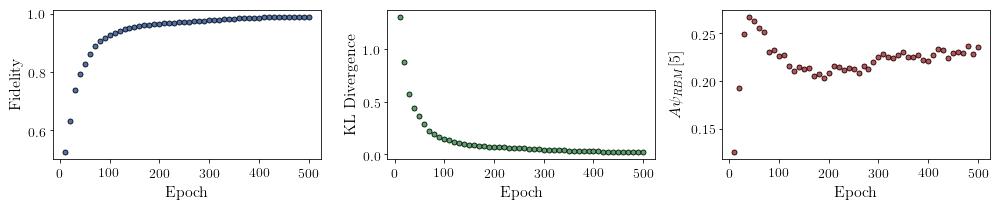

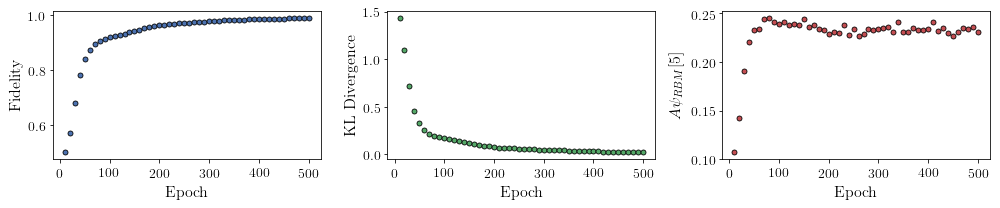

>>>>>>> remote


In [10]:
# Plotting
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 3))
ax = axs[0]
ax.plot(epoch, fidelities, "o", color="C0", markeredgecolor="black")
ax.set_ylabel(r"Fidelity")
ax.set_xlabel(r"Epoch")

ax = axs[1]
ax.plot(epoch, KLs, "o", color="C1", markeredgecolor="black")
ax.set_ylabel(r"KL Divergence")
ax.set_xlabel(r"Epoch")

ax = axs[2]
ax.plot(epoch, coeffs, "o", color="C2", markeredgecolor="black")
ax.set_ylabel(r"$A\psi_{RBM}[5]$")
ax.set_xlabel(r"Epoch")

plt.tight_layout()
plt.savefig("fid_KL.pdf")
plt.show()

It should be noted that one could have just ran `nn_state.fit(train_samples)`, which uses the default hyperparameters and no training evaluators.

To demonstrate how important it is to find the optimal hyperparameters for a certain system, restart this notebook and comment out the original `fit` statement, then uncomment and run the cell below.

In [11]:
# nn_state.fit(train_samples)

Using the non-default hyperparameters yielded a fidelity of approximately $0.989$, while the default hyperparameters yield approximately $0.523$!

The trained RBM's parameters are saved to a pickle file with the name `saved_params.pt` for future use in other tutorials:

<<<<<<< LOCAL CELL DELETED >>>>>>>
It should be noted that one could have just ran `nn_state.fit(train_samples)` and just used the default hyperparameters and no training evaluators.

To demonstrate how important it is to find the optimal hyperparameters for a certain system, restart this notebook and comment out the original `fit` statement and uncomment the one below. The default hyperparameters will be used instead. Using the custom hyperparameters yielded a fidelity of approximately $0.994$, while the default hyperparameters yielded a fidelity of approximately $0.523$!

The RBM's parameters will also be saved for future use in other tutorials. They can be saved to a pickle file with the name `saved_params.pt` with the code below.

In [12]:
nn_state.save("saved_params.pt")

This saves the weights, visible biases and hidden biases as torch tensors with the following keys: `weights`, `visible_bias`, `hidden_bias`.